# DBSCAN
This notebook is split into three sections with one for every algorithm.
Essentially, the idea is to cluster movies and users so that we can
recommend the entire cluster they belong to, for both users and movies.

Compared to the other algorithms, this means that we will not be able
to give exactly how much they like a given movie, but just give them
the cluster they reside in.

## Initialise PySpark and data

In [32]:
from random import random
import time

from sklearn.decomposition import PCA
from pyspark.ml.linalg import DenseVector
from pyspark.mllib.random import RandomRDDs
import pyspark.sql
import pyspark
import pandas as pd
from pyspark import SparkContext, SparkConf, SQLContext
from sklearn.cluster import DBSCAN
import os
import numpy as np

if os.path.basename(os.getcwd()) == 'density':
    print("Current dir is", os.getcwd())
    print("Changing dir to be in root")
    os.chdir('..')
    print('now in', os.getcwd())

from proposal.useful_tools import pickle_manager

SPARK_CONF = SparkConf()
SPARK_CONF.set("spark.driver.memory", "10g")
SPARK_CONF.set("spark.cores.max", "4")
SPARK_CONF.set("spark.executor.heartbeatInterval", "3600")
SPARK_CONF.setAppName("word2vec")

SPARK_CONTEXT = SparkContext.getOrCreate(SPARK_CONF)
SPARK = SQLContext(SPARK_CONTEXT)

np.random.seed(42)

In [33]:
MOVIES: pd.DataFrame = pickle_manager.load_pickle(
    'pickles/sentences.pickle.lz4'
)
print(MOVIES.head())

MOVIES_FEATURES: pd.DataFrame = pickle_manager.load_pickle(
    'pickles/sentence_features.pickle.lz4'
)
print(MOVIES_FEATURES.head())
MOVIES_FEATURES = MOVIES_FEATURES.reset_index().to_numpy(dtype=np.float64)

# Huh apparently we have nan. If we set to 0 then it should be fine
MOVIES_FEATURES[np.isnan(MOVIES_FEATURES)] = 0
print(MOVIES_FEATURES)

pca_maker = PCA(n_components=2)
PCA_DATA = pca_maker.fit_transform(MOVIES_FEATURES)
print(PCA_DATA)

      imdbId                        title  \
0  tt0000009                   Miss Jerry   
1  tt0000574  The Story of the Kelly Gang   
2  tt0001892               Den sorte drøm   
3  tt0002101                    Cleopatra   
4  tt0002130                    L'Inferno   

                                         description  \
0   The adventures of a female reporter in the 1890s   
1  True story of notorious Australian outlaw Ned ...   
2  Two men of high rank are both wooing the beaut...   
3  The fabled queen of Egypt's affair with Roman ...   
4  Loosely adapted from Dante's Divine Comedy and...   

                               processed_description  
0                   [adventur, femal, report, 1890s]  
1  [true, stori, notori, australian, outlaw, ned,...  
2  [two, men, high, rank, woo, beauti, famous, eq...  
3  [fabl, queen, egypt, affair, roman, general, m...  
4  [loos, adapt, dant, divin, comedi, inspir, ill...  
         0         1         2         3         4         5  

In [34]:
unzipped_PCA_DATA = list(zip(*PCA_DATA))

PCA_x, PCA_y = unzipped_PCA_DATA[0], unzipped_PCA_DATA[1]
print(PCA_DATA[0])

[-4.29270000e+04  2.42203179e-01]


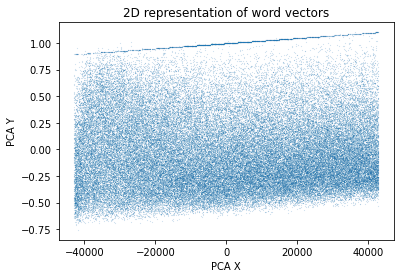

In [35]:
import matplotlib.pyplot as plt

plt.scatter(PCA_x, PCA_y, s=0.005)
plt.title("2D representation of word vectors")
plt.xlabel("PCA X")
plt.ylabel("PCA Y")
plt.show()

So we actually have a pretty cool way to represent clusters visually by doing this! Ideally we can break
this into chunks of movies with 100 or so recommendations. In theory, it should not just turn brown, but it
might.

## Finding Optimal Parameters
To be safe with defining epsilon and radius, it was decided that the library
will be used first. This can let us just train for the optimal
epsilon and minimum samples while knowing it works.

If you open a website for movies, you probably want to see at least 100 movies.
Let's assume that's our minimum number of points then.

In [36]:
# This is probably going to light up as copied from somewhere
MIN_POINTS = 100

from sklearn.neighbors import NearestNeighbors


def find_distances(minpoints, features):
    start = time.perf_counter()
    neighbors = NearestNeighbors(n_neighbors=minpoints)
    neighbors_fit = neighbors.fit(features)
    distances, indices = neighbors_fit.kneighbors(features)
    print("That took", time.perf_counter() - start)
    return distances, indices


distances, indices = find_distances(MIN_POINTS, MOVIES_FEATURES)

That took 16.506924599999934


25.070127915020123
[[    0     1     2 ...    97    98    99]
 [    1     0     2 ...    97    98    99]
 [    2     3     1 ...    97    98    99]
 ...
 [85852 85853 85851 ... 85757 85756 85755]
 [85853 85852 85854 ... 85757 85756 85755]
 [85854 85853 85852 ... 85757 85756 85755]]
(100,)
max 99.00732891662456
min 50.0
mean 50.040675067492536
median 50.0118111231062


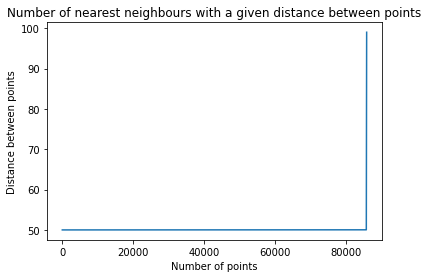

In [37]:
def show_nearest_neighbours(distances, indices):
    print(np.average(distances))
    print(indices)
    print(distances[0].shape)

    max_neighbours_distances = distances[:, -1]
    max_neighbours_distances = np.sort(max_neighbours_distances)

    max = np.max(max_neighbours_distances)
    min = np.min(max_neighbours_distances)
    average = np.average(max_neighbours_distances)
    median = np.median(max_neighbours_distances)

    print('max', np.max(max_neighbours_distances))
    print('min', np.min(max_neighbours_distances))
    print('mean', np.average(max_neighbours_distances))
    print('median', np.median(max_neighbours_distances))

    plt.plot(max_neighbours_distances)
    plt.title('Number of nearest neighbours with a given distance between points')
    plt.xlabel('Number of points')
    plt.ylabel('Distance between points')
    plt.show()

    return max_neighbours_distances


max_neighbours_distances = show_nearest_neighbours(distances, indices)

Our ideal value for epsilon is going to be sitting right at that turn in the centre. Most
people just eye the value, but we can actually just use the second derivative to find this point.

First issue is that this is not a continuous function, so we are going to have to find the
discrete form of how to find the second derivative.

Taking the derivative by first principle:
$$
    \frac{dy}{dx} = \lim_{h \rightarrow 0} \frac{f(x+h) - f(x)}{h}
$$

Now to convert this to discrete values, we know that h does exist and cannot
be infinitely close to 0 anymore. Instead, we are forced to select this distance
by the space between the points, which should be 1 in our case.

For our second derivative, we have to find the derivative of the values around the point
then the derivative of those changes. So we do:

In [38]:
def find_max_curve(max_neighbours_distances):
    maximum_curve = 0
    maximum_curve_index = 0

    # We need to use the point in front and behind so we need
    # to start at 1 and end one early
    for i in range(500, len(max_neighbours_distances) - 1):
        a_to_b = max_neighbours_distances[i - 1] - max_neighbours_distances[i]
        b_to_c = max_neighbours_distances[i + 1] - max_neighbours_distances[i]
        second_derivative = b_to_c - a_to_b
        if i == 1:
            maximum_curve = second_derivative
            maximum_curve_index = 1

        if second_derivative > maximum_curve:
            maximum_curve = second_derivative
            maximum_curve_index = i
    return maximum_curve, maximum_curve_index


maximum_curve, maximum_curve_index = find_max_curve(max_neighbours_distances)

In [39]:
print("Maximum curvature occurs at", maximum_curve_index)
epsilon = max_neighbours_distances[maximum_curve_index]
print("That distance is", epsilon)

Maximum curvature occurs at 85761
That distance is 53.00965234322805


Now that is a lot of possible inflections. Odds are that a lot of them are between 0 and 20,000 and 80,000
for us though.

## Scikit DBSCAN
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)
### Implementation

In [40]:
start = time.perf_counter()
scikit_movies_clustering = DBSCAN(
    eps=epsilon, min_samples=MIN_POINTS
).fit(MOVIES_FEATURES)
print("Took", time.perf_counter() - start, "seconds")

Took 23.827112599999964 seconds


In [41]:
def count_noise(labels):
    count = 0
    for i in labels:
        if i == -1:
            count += 1
    return count


print(scikit_movies_clustering.labels_)
print("Unique labels", set(scikit_movies_clustering.labels_))
print("Number of noise points", count_noise(scikit_movies_clustering.labels_))

print("Frequency table", np.unique(np.unique(scikit_movies_clustering.labels_, return_counts=True)))

[0 0 0 ... 0 0 0]
Unique labels {0}
Number of noise points 0
Frequency table [    0 85855]


That's not a great outcome. Let's try a couple more potential values that were chosen earlier

In [42]:
from sklearn import metrics


def evaluate_measurement(name, epsilon, features=MOVIES_FEATURES):
    print("========= Trying", name, epsilon, "==============")
    start = time.perf_counter()
    scikit_movies_clustering = DBSCAN(
        eps=epsilon, min_samples=MIN_POINTS
    ).fit(features)
    print("Took", time.perf_counter() - start, "seconds")

    print("Number of clusters",
          len(set(scikit_movies_clustering.labels_)) - (1 if -1 in scikit_movies_clustering.labels_ else 0))
    print("Noise fraction", list(scikit_movies_clustering.labels_).count(-1) / len(scikit_movies_clustering.labels_))
    print("Frequency table", np.unique(scikit_movies_clustering.labels_, return_counts=True))

# This takes a long time to calculate so its left out for now
# print("Silhouette Coefficient", metrics.silhouette_score(MOVIES_FEATURES, scikit_movies_clustering.labels_))

In [43]:
try_out = {
    'min on max_neighbours': np.min(max_neighbours_distances),
    'average on max_neighbours': np.average(max_neighbours_distances),
    'median on max_neighbours': np.median(max_neighbours_distances),
    'average on all distances': np.average(distances),
    'median on all distances': np.median(distances),
}

for key, value in try_out.items():
    evaluate_measurement(key, value)

========= Trying min on max_neighbours 50.0 ==============
Took 23.387909700000023 seconds
Number of clusters 54
Noise fraction 0.9014850620231786
Frequency table (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53], dtype=int64), array([77397,   149,   149,   149,   149,   149,   199,   157,   149,
         149,   149,   149,   149,   149,   149,   149,   232,   154,
         149,   149,   246,   149,   149,   149,   149,   149,   149,
         149,   149,   149,   149,   149,   149,   149,   149,   195,
         149,   149,   149,   149,   149,   149,   235,   220,   115,
         149,   149,   149,   149,   149,   149,   149,   149,   149,
         149], dtype=int64))
========= Trying average on max_neighbours 50.040675067492536 ==============
Took 23.22607329999994 seconds
Number of cluste

In [44]:
# Try out  a number below 50 as well
evaluate_measurement('below 50', 49.99)

========= Trying below 50 49.99 ==============
Took 22.51917459999993 seconds
Number of clusters 0
Noise fraction 1.0
Frequency table (array([-1], dtype=int64), array([85855], dtype=int64))


# Moving Forwards
So overall we can see that this is not a very functional idea. A distance of 50 gives us 54 clusters and mostly noise,
but then if we take it up to 50.01 then that noise is all crushed into a single cluster anyways. Let's quickly make a
graph for that 54 cluster group to visualise how its working out:

In [45]:
import matplotlib as mpl


def make_plot(dbscan, pca_x, pca_y):
    N = len(np.unique(dbscan.labels_))
    print(N, "labels")
    colour_map = plt.cm.jet
    colour_map_list = [colour_map(i) for i in range(colour_map.N)]
    colour_map = colour_map.from_list('Neat colours', colour_map_list, colour_map.N)

    bounds = np.linspace(0, N, N + 1)
    norm = mpl.colors.BoundaryNorm(bounds, colour_map.N)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    scatter = ax.scatter(pca_x, pca_y, c=dbscan.labels_, cmap=colour_map, s=0.005, norm=norm)
    cb = plt.colorbar(scatter, spacing='proportional', ticks=bounds)
    cb.set_label('Cluster colours')

    ax.set_title('Clusters')
    ax.set_xlabel('pca x')
    ax.set_ylabel('pca y')

    plt.show()

55 labels


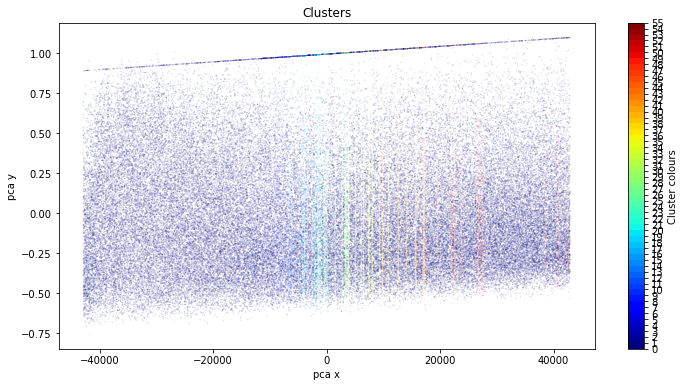

In [46]:
# Min was 50
dbscan = DBSCAN(
        eps=np.min(max_neighbours_distances), min_samples=MIN_POINTS
    ).fit(MOVIES_FEATURES)

make_plot(
    dbscan, PCA_x, PCA_y
)

In [47]:
print("Silhouette Coefficient", metrics.silhouette_score(MOVIES_FEATURES, dbscan.labels_))

Silhouette Coefficient -0.7523968004433775


2 labels


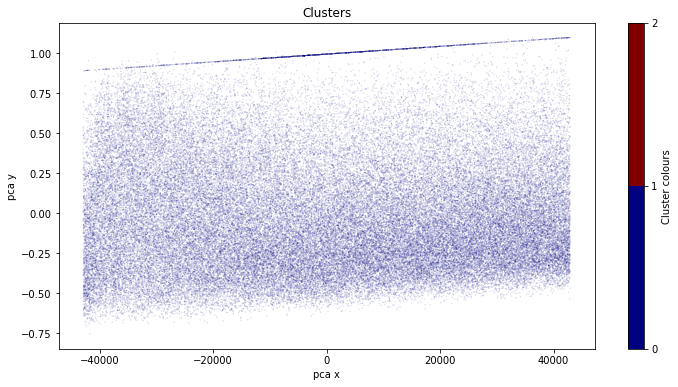

In [48]:
# Median was 50.04
dbscan = DBSCAN(
    eps=np.median(max_neighbours_distances), min_samples=MIN_POINTS
).fit(MOVIES_FEATURES)

make_plot(
    dbscan, PCA_x, PCA_y
)

In [49]:
print("Silhouette Coefficient", metrics.silhouette_score(MOVIES_FEATURES, dbscan.labels_))

Silhouette Coefficient 0.17556970368875852


Well, that looks cool, but it highlights the problem. We can see that at 50.01 we have a couple of very small
clusters, then at 50.04 it makes everything into one cluster. So let's try out using the data that was generated for
knn. Maybe that's better.

In [50]:
MOVIES_SIMILARITY_MATRIX = pickle_manager.load_pickle('pickles/similarity_matrix.pickle.lz4')
print(MOVIES_SIMILARITY_MATRIX)

[[1.         0.05882353 0.06063391 ... 0.06063391 0.         0.        ]
 [0.05882353 1.         0.06063391 ... 0.         0.         0.070014  ]
 [0.06063391 0.06063391 1.         ... 0.         0.         0.        ]
 ...
 [0.06063391 0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.070014   0.         ... 0.         0.         1.        ]]


Now that similarity matrix is an issue. We actually need a distances matrix, not a similarity one for clustering.
Otherwise elements that are very similar are 1 units away, while the complete opposites are 0 units away. So that
needs to be inverted. Also, an element does get compared to itself in this matrix, so we need to just set
that horizontal to 0.

In [51]:
def crush(x):
    if x < 0:
        x = 0
    elif x > 1:
        x = 1
    return x


crush_v = np.vectorize(crush)
MOVIES_SIMILARITY_MATRIX = crush_v(np.subtract(1.0, MOVIES_SIMILARITY_MATRIX))
print("Number of different distances", len(set(MOVIES_SIMILARITY_MATRIX.flatten())))

print("############")
print(MOVIES_SIMILARITY_MATRIX)

Number of different distances 267
############
[[0.         0.94117647 0.93936609 ... 0.93936609 1.         1.        ]
 [0.94117647 0.         0.93936609 ... 1.         1.         0.929986  ]
 [0.93936609 0.93936609 0.         ... 1.         1.         1.        ]
 ...
 [0.93936609 1.         1.         ... 0.         1.         1.        ]
 [1.         1.         1.         ... 1.         0.         1.        ]
 [1.         0.929986   1.         ... 1.         1.         0.        ]]


That took 9.61903970000003
1.2766681777763482
[[   0  999 1827 ... 1027  387 1717]
 [   1 1596  544 ... 1926  739 1343]
 [   2 1517  919 ... 1652 1750  733]
 ...
 [1997 1977 1134 ...  128 1732 1308]
 [1998 1034 1526 ... 1689 1917  838]
 [1999 1593  424 ... 1569 1983  753]]
(20,)
max 3.4259431871864954
min 1.1805497284092834
mean 1.3989825276589374
median 1.3341277504703826


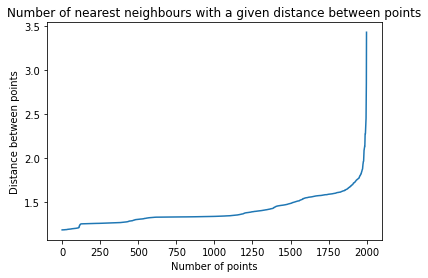

Elbow is at 2.843732885569378


In [52]:
# Generate elbow
# Given our dataset is 2000 points, let's say our number of points is 20

MIN_POINTS = 20

knn_distances, indices = find_distances(MIN_POINTS, MOVIES_SIMILARITY_MATRIX)
knn_max_neighbours_distances = show_nearest_neighbours(knn_distances, indices)
maximum_curve, maximum_curve_index = find_max_curve(knn_max_neighbours_distances)
epsilon = knn_max_neighbours_distances[maximum_curve_index]
print("Elbow is at", epsilon)

Sadly we do not have a PCA representation of this, so we can't make a plot. However, we can still spit
out the number of clusters and silhouette coeffecient to compare.

In [53]:
start = time.perf_counter()
dbscan = DBSCAN(
    eps=epsilon,
    min_samples=MIN_POINTS,
    metric='precomputed',
    n_jobs=-1
).fit(MOVIES_SIMILARITY_MATRIX)
print("That took", time.perf_counter() - start, "seconds")

That took 0.0783449999998993 seconds


In [54]:
print("Number of clusters",
      len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0))
print("Noise fraction", list(dbscan.labels_).count(-1) / len(dbscan.labels_))
print("Frequency table", np.unique(dbscan.labels_, return_counts=True))
try:
    print("Silhouette Coefficient", metrics.silhouette_score(MOVIES_SIMILARITY_MATRIX, dbscan.labels_))
except:
    print("Silhouette coeffecient cannot be calculated as there are not enough clusters")

Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Silhouette coeffecient cannot be calculated as there are not enough clusters


Well, once again our elbow has failed us. Let's try some other values

In [55]:
def run_and_evaluate_movie_sim(title, epsilon_f, min_pts=MIN_POINTS, function_to_use=DBSCAN):
    try:
        print("=====Trying out", title, epsilon_f, '=========')
        start = time.perf_counter()
        dbscan = function_to_use(
            eps=epsilon_f,
            min_samples=min_pts,
            metric='precomputed',
            n_jobs=-1
        ).fit(MOVIES_SIMILARITY_MATRIX)
        print("That took", time.perf_counter() - start, "seconds")

        number_of_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
        noise_fraction = list(dbscan.labels_).count(-1) / len(dbscan.labels_)

        print("Number of clusters", number_of_clusters)
        print("Noise fraction", noise_fraction)
        print("Frequency table", np.unique(dbscan.labels_, return_counts=True))

        sc = metrics.silhouette_score(MOVIES_SIMILARITY_MATRIX, dbscan.labels_)
        print("Silhouette Coefficient", sc)
        # Since its a lot faster this time, we can catually calculate this
        return number_of_clusters, noise_fraction, sc
    except:
        print("Something went wrong. Moving onto the next value")
        return 0, 0, 0

In [56]:
try_out = {
    'min on max_neighbours': np.min(knn_max_neighbours_distances),
    'average on max_neighbours': np.average(knn_max_neighbours_distances),
    'median on max_neighbours': np.median(knn_max_neighbours_distances),
    'min on all distances': np.average(knn_distances),
    'max on all distances': np.median(knn_distances),
    'average on all distances': np.average(knn_distances),
    'median on all distances': np.median(knn_distances),
    '25% sim': 0.25,
    '50% sim': 0.5,
    '65% sim': 0.65,
    '75% sim': 0.75,
    '85% sim': 0.85,
    '95% sim': 0.95
}

for key, value in try_out.items():
    run_and_evaluate_movie_sim(key, value)

=====Trying out min on max_neighbours 1.1805497284092834 =========
That took 0.07321189999993294 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out average on max_neighbours 1.3989825276589374 =========
That took 0.07733980000011798 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out median on max_neighbours 1.3341277504703826 =========
That took 0.0746024000000034 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out min on all distances 1.2766681777763482 =========
That took 0.07586369999989984 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dt

Right so all of those are bad too, let's try changing the minimum points as well. We are getting
some silhouette coefficients, but never enough clusters.

In [57]:
possible_min_pts = [
    2, 5, 10, 15
]

for m in possible_min_pts:
    for key, value in try_out.items():
        run_and_evaluate_movie_sim(
            str(key + str(m)), value, m
        )

=====Trying out min on max_neighbours2 1.1805497284092834 =========
That took 0.08626479999998082 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out average on max_neighbours2 1.3989825276589374 =========
That took 0.07247980000011012 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out median on max_neighbours2 1.3341277504703826 =========
That took 0.07738170000015998 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out min on all distances2 1.2766681777763482 =========
That took 0.06709150000006048 seconds
Number of clusters 1
Noise fraction 0.0
Frequency table (array([0], dtype=int64), array([2000

In the middle of all that is a value at 26 clusters, but the frequency table says that the clusters only have a
size of two. Overall, this is even worse than word vectors then. It was worth checking, but it does not have unique
enough data.
# By Hand Implementation
This was done inside the slides_dbscan.py file for convenience (jupyter notebooks are terrible for frequently
refactored code) with a class that overrides the fitting function of scitkit. Since that's independent and
the rest of the algorithm can be run without it, it should be permitted.

Now an obvious issue was encountered, which is just the speed of python. Python is an extremely slow
language, and scikit is most definitely pulling some optimisations in their pairwise calculations
that do not happen in regular calculations. To showcase this, let's see how long it takes
to calculate dbscan on three nodes (so comparing to 80,000 other rows with 100 features each)

In [58]:
from slides_dbscan import slides_dbscan

start = time.perf_counter()
clusters, noise = slides_dbscan(
    MOVIES_FEATURES, np.min(max_neighbours_distances), minimum_points=100,
    down_to=len(MOVIES_FEATURES) - 3
)
print("That took", time.perf_counter() - start, "seconds")

85855
85854
85853
That took 22.09755300000006 seconds


Okay, well, that is a long time for just three rows when we need to go through 80,000. How
about if I do some basic optimisations by swapping the euclidean distance calculation to
use njit (compiler that translates python into lower level code, often making it hundreds
of times faster), and swap the calculation to use numpy along with it.

In [59]:
from optimised_by_hand_dbscan import optimised_slides_dbscan
from slides_dbscan import slides_dbscan

start = time.perf_counter()
clusters, noise = optimised_slides_dbscan(
    MOVIES_FEATURES, np.min(max_neighbours_distances), minimum_points=100,
    down_to=len(MOVIES_FEATURES) - 3
)
print("That took", time.perf_counter() - start, "seconds")

That took 0.14439339999989897 seconds


Okay cool, that looks a little more viable. How does it scale?

In [60]:
start = time.perf_counter()
clusters, noise = optimised_slides_dbscan(
    MOVIES_FEATURES, np.min(max_neighbours_distances), minimum_points=100,
    down_to=len(MOVIES_FEATURES) - 50
)
print("That took", time.perf_counter() - start, "seconds")

That took 2.2623313999999937 seconds


Well, that's still going to take (85836/50)*2.32=3,982 seconds (1.1 hours).
Even if we do run that, scikit is managing to do it in under twenty seconds.
If it achieves the same results, it just is not worth even trying.

Looking at how scikit manages to do it, the magic lies in their pairwise calculations.
When numpy does maths on a two dimensional array, its maths scales well
and it manages to keep up. So to make it the same speed we would have to start using
numpy's matrix maths, or scikit's full pairwise calculation.

We can quickly check if this is in fact true. This version of by hand dbscan
uses scikit's `distance.euclidean` function, for just calculating two arrays.

In [61]:
from scikit_euclid_hand_clustering import scikit_distances_dbscan

start = time.perf_counter()
clusters, noise = scikit_distances_dbscan(
    MOVIES_FEATURES, np.min(max_neighbours_distances), minimum_points=100,
    down_to=len(MOVIES_FEATURES) - 20
)
print("That took", time.perf_counter() - start, "seconds")

85855
85854
85853
85852
85851
85850
85849
85848
85847
85846
85845
85844
85843
85842
85841
85840
85839
85838
85837
85836
That took 18.272198300000127 seconds


We can see that its actually slower than our numbas optimisation, but is around ten times faster
than just properly plain python.

Personally, compared to just using the plain numpy maths and njit to change the compiled code
into C level code, I would say that using numpy's two dimensional matrix multiplication
optimisation is breaking the assignment's 'no other libraries' rule - even though it's been stretched
it far enough as is.

For now, let's at least compromise and prove that this algorithm does function by using
it on the distance matrix produced by kNN instead.
## Distance Matrix by Hand
This is hopping a bit back and forth between ideas, but at least this is short. Since
this is actually a fast operation, we can

=====Trying out 2000 matrix by hand parameters 0.6 =========
That took 0.9038021999999728 seconds
Number of clusters 0
Noise fraction 1.0
Frequency table (array([-1.]), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out 2000 matrix with the same parameters 0.6 =========
That took 0.033364999999776046 seconds
Number of clusters 0
Noise fraction 1.0
Frequency table (array([-1], dtype=int64), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out 2000 matrix by hand parameters 0.65 =========
That took 0.7987435999998524 seconds
Number of clusters 0
Noise fraction 1.0
Frequency table (array([-1.]), array([2000], dtype=int64))
Something went wrong. Moving onto the next value
=====Trying out 2000 matrix with the same parameters 0.65 =========
That took 0.031123199999910867 seconds
Number of clusters 1
Noise fraction 0.99
Frequency table (array([-1,  0], dtype=int64), array([1980,   20], dtype=int64))
Silhouette C

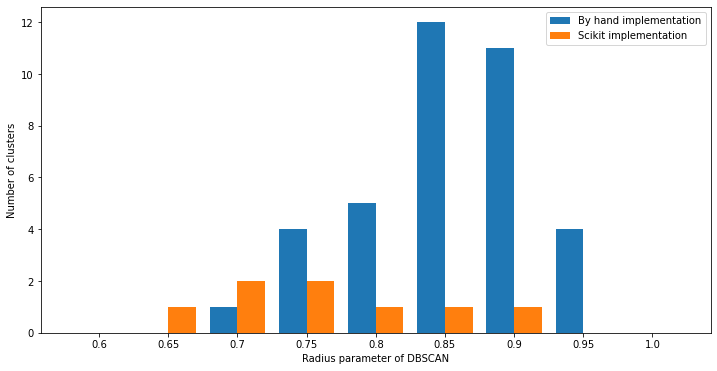

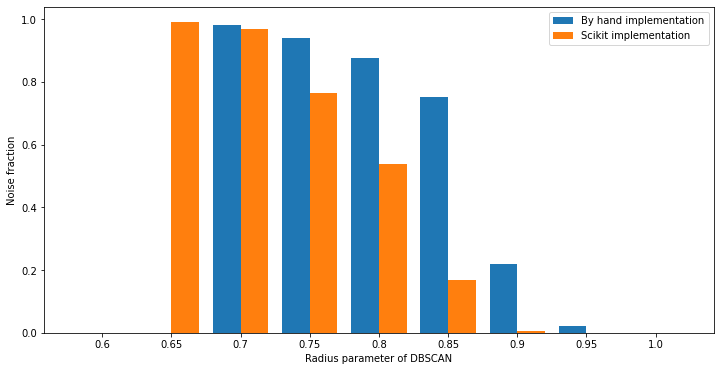

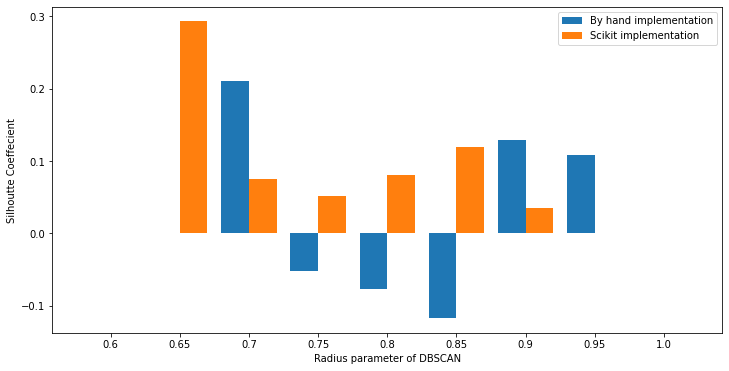

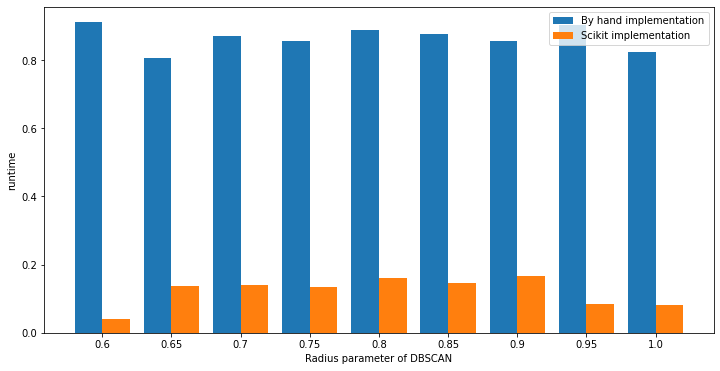

In [77]:
from slides_distance_matrix import sim_my_DBSCAN


def graph_range_of_epsilon(epsilon_start, epsilon_end, step_size):
    result_names = [
        'Number of clusters', 'Noise fraction', 'Silhoutte Coeffecient', 'runtime'
    ]
    by_hand_properties = [
        [], [], [], []
    ]
    scikit_results = [
        [], [], [], []
    ]
    for i in np.arange(epsilon_start, epsilon_end, step_size):
        start = time.perf_counter()
        number_of_clusters, noise_fraction, sc = \
            run_and_evaluate_movie_sim(
                '2000 matrix by hand parameters', epsilon_f=i, min_pts=20, function_to_use=sim_my_DBSCAN
            )
        by_hand_properties[0].append(number_of_clusters)
        by_hand_properties[1].append(noise_fraction)
        by_hand_properties[2].append(sc)
        by_hand_properties[3].append(time.perf_counter() - start)

        start = time.perf_counter()
        number_of_clusters, noise_fraction, sc = \
            run_and_evaluate_movie_sim(
                '2000 matrix with the same parameters', epsilon_f=i, min_pts=20
            )
        scikit_results[0].append(number_of_clusters)
        scikit_results[1].append(noise_fraction)
        scikit_results[2].append(sc)
        scikit_results[3].append(time.perf_counter() - start)

    for i in np.arange(len(result_names)):
        f = plt.figure()
        f.set_figwidth(12)
        f.set_figheight(6)

        X_axis = np.arange(len(np.arange(epsilon_start, epsilon_end, step_size)))

        plt.bar(
            X_axis - 0.2, by_hand_properties[i], 0.4, label='By hand implementation'
        )
        plt.bar(
            X_axis +0.2, scikit_results[i], 0.4, label='Scikit implementation'
        )
        xlabels = np.around(np.arange(epsilon_start, epsilon_end, step_size), 3).astype(str)

        plt.xticks(X_axis, xlabels)

        plt.xlabel('Radius parameter of DBSCAN')
        plt.ylabel(result_names[i])

        plt.legend()
        plt.show()

graph_range_of_epsilon(
    0.6, 1.05, 0.05
)